In [1]:
import numpy as np
import itertools
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy as sp
from scipy.stats import linregress

from sklearn.model_selection import KFold, LeaveOneOut

from bamf.bamf import *

import time

np.random.seed(12345)

# Define number of K-Folds 

In [2]:
# Comment out if using Leave One Out
K = 3

# Define variable names

In [3]:
# number of species
NS = 7

species = ["s"+str(i+1) for i in range(NS)]
species

['s1', 's2', 's3', 's4', 's5', 's6', 's7']

# Import sequenced data

In [4]:
full_data = pd.read_csv("gLV_data/Simulated_gLV_data_full.csv")
full_data

,Treatments,Time,s1,s2,s3,s4,s5,s6,s7
0,exp_1,0.0,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000
1,exp_1,48.0,0.298559,0.159095,0.081960,0.215479,0.016468,0.168590,0.000057
2,exp_2,0.0,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,0.000000
3,exp_2,48.0,0.286262,0.165522,0.065139,0.155305,0.025074,0.212555,0.000000
4,exp_3,0.0,0.100000,0.100000,0.100000,0.100000,0.100000,0.000000,0.100000
...,...,...,...,...,...,...,...,...,...
249,exp_125,48.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.337060,0.118508
250,mono_exp_126,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.100000,0.000000
251,mono_exp_126,48.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.548540,0.000000
252,mono_exp_127,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.100000


## sum-of-OD data

In [5]:
sum_data = pd.read_csv("gLV_data/Simulated_gLV_data_sum.csv")
sum_data

,Treatments,Time,OD,s1,s2,s3,s4,s5,s6,s7
0,exp_1,0.0,0.700000,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000
1,exp_1,1.0,0.603124,0.139175,0.115084,0.112920,0.111055,0.104585,0.116198,0.086675
2,exp_1,2.0,0.863875,0.180531,0.128074,0.122424,0.121131,0.104713,0.130274,0.073863
3,exp_1,3.0,1.025633,0.218637,0.138798,0.128066,0.130070,0.101389,0.141819,0.062099
4,exp_1,4.0,0.868276,0.249608,0.147425,0.130253,0.137868,0.096018,0.150858,0.051734
...,...,...,...,...,...,...,...,...,...,...
6218,mono_exp_127,44.0,0.149115,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.144137
6219,mono_exp_127,45.0,0.157048,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.144124
6220,mono_exp_127,46.0,0.126141,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.144121
6221,mono_exp_127,47.0,0.133857,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.144130


# Define function to make predictions on test data

In [6]:
# Define function to make predictions on test data

def test_model(model, df_test, species, plot=False):
    all_treatments = df_test.Treatments.values
    unique_treatments = np.unique(all_treatments)
    numspecies = len(species)

    # save true and predicted values
    y_true = []
    y_pred = []
    y_std  = []
    test_treatments = []
    test_times = []
    all_species_names = []

    # pull a random community trajectory
    for treatment in unique_treatments:
        comm_inds = np.in1d(df_test['Treatments'].values, treatment)
        comm_data = df_test.iloc[comm_inds].copy()

        # make sure comm_data is sorted in chronological order
        comm_data.sort_values(by='Time', ascending=True, inplace=True)
        tspan = comm_data.Time.values

        # pull just the community data
        output_true = comm_data[species].values

        # run model using parameters
        x_test = np.copy(output_true[0, :])

        # test full community
        output, stdv, COV = model.predict(x_test, tspan)

        # save predictions after initial value 
        for i, (true, pred, std) in enumerate(zip(output_true[1:], output[1:], stdv[1:])):
            y_true += list(true)
            y_pred += list(pred)
            y_std  += list(std)
            test_times += [tspan[i+1]]*numspecies
            all_species_names += list(species)
            test_treatments += [treatment]*numspecies

        if plot:
            # increase teval
            t_eval = np.linspace(0, tspan[-1]+5)
            steps = len(t_eval)
            output, stdv, COV = model.predict(x_test, t_eval)   

            # plot the results
            plt.figure(figsize=(9, 6))
            ylim = 0
            for i in range(numspecies):
                out = output[:,i]
                out_true = output_true[:, i]
                std = stdv[:, i]
                if ylim < np.max([np.max(out) + np.max(std)+.1, np.max(out_true)+.1]):
                    ylim = np.max([np.max(out) + np.max(std)+.1, np.max(out_true)+.1])
                if out[0] > 0:
                    plt.scatter(tspan, out_true, color='C{}'.format(i))
                    plt.plot(t_eval, out, label=f"Predicted {species[i]}", color='C{}'.format(i))
                    plt.fill_between(t_eval, out-std, out+std, color='C{}'.format(i), alpha=0.2)

            plt.xlabel("time", fontsize=16)
            plt.ylabel("Abundance", fontsize=16)
            plt.legend(loc='upper left')
            plt.ylim([0, np.min([ylim, 3])])
            plt.title(f"Treatment {treatment} predictions")
            #plt.savefig("Kfold/Figures/{}_{}.pdf".format(dataset.replace("_",""), treatment.replace("<","")))
            #plt.close()
            plt.show()

    return test_treatments, test_times, all_species_names, y_true, y_pred, y_std

# Define function to make predictions on test data

def test_mf(model, df_test, species, plot=False):
    all_treatments = df_test.Treatments.values
    unique_treatments = np.unique(all_treatments)
    numspecies = len(species)

    # save true and predicted values
    y_true = []
    y_pred = []
    y_std  = []
    test_treatments = []
    test_times = []
    all_species_names = []

    # pull a random community trajectory
    for treatment in unique_treatments:
        comm_inds = np.in1d(df_test['Treatments'].values, treatment)
        comm_data = df_test.iloc[comm_inds].copy()

        # make sure comm_data is sorted in chronological order
        comm_data.sort_values(by='Time', ascending=True, inplace=True)
        tspan = comm_data.Time.values

        # pull just the community data
        output_true = comm_data[species].values

        # run model using parameters
        x_test = np.copy(output_true[0, :])

        # increase teval
        t_eval = np.linspace(0, tspan[-1]+5)
        steps = len(t_eval)
        output, stdv, COV = model.predict(x_test, t_eval)   
        
        # apply lossy function
        output_true = np.sum(output_true, 1)
        output = np.sum(output, 1)
        stdv = np.sum(stdv, 1)

        # plot the results
        plt.figure(figsize=(9, 6))
        plt.scatter(tspan, output_true, color='C0')
        plt.plot(t_eval, output, label=f"Predicted sum", color='C0')
        plt.fill_between(t_eval, output-stdv, output+stdv, color='C0', alpha=0.2)

        plt.xlabel("time", fontsize=16)
        plt.ylabel("Abundance", fontsize=16)
        plt.legend(loc='upper left')
        plt.title(f"Treatment {treatment} predictions")
        #plt.savefig("Kfold/Figures/{}_{}.pdf".format(dataset.replace("_",""), treatment.replace("<","")))
        #plt.close()
        plt.show()

# Initialize model parameters

In [7]:
# system dimensions
ns = len(species)
nu = 0

# map to hidden dimension
stdv = 1./np.sqrt(ns*ns)
A = np.random.uniform(0, -stdv, [ns, ns])
a = np.random.uniform(0, stdv, ns)

# concatenate parameters 
params = np.concatenate((A.flatten(), a))
prior  = np.zeros_like(params)

n_params = len(params)
n_params

56

# Define model

In [8]:
# using NODE model 
def system(t, s, params, ctrl_params): 
    
    # map to hidden dimension
    A = jnp.reshape(params[:ns**2], [ns,ns])
    a = params[ns**2:]

    # rate of change of species 
    dsdt = s * (A@s + a)

    return dsdt

# Define compression functions

In [9]:
# define compression functions 
compressor0 = lambda x: jnp.expand_dims(jnp.sum(x), 0)     # sum over outputs 
compressor1 = lambda x: x

compressors = [compressor1]

In [10]:
# pull treatment names 
all_sum_treatments = sum_data.Treatments.values
all_treatments = full_data.Treatments.values
unique_treatments = np.unique(all_treatments)

# set up kfold iterator
kf = KFold(n_splits = K) 

# set up list of measured and predicted values
kfold_species_names = []
kfold_y_true = []
kfold_y_pred = []
kfold_y_stdv = []

# iterate over folds 
for train_index, test_index in kf.split(unique_treatments):
    # train_index, test_index = next(iter(kf.split(unique_treatments)))

    # get index of train and test data
    train_inds_sum = np.in1d(all_sum_treatments, unique_treatments[train_index])
    train_inds = np.in1d(all_treatments, unique_treatments[train_index])
    test_inds  = np.in1d(all_treatments, unique_treatments[test_index])

    # pull out train and test data 
    df_train_sum = sum_data.iloc[train_inds_sum].copy()
    df_train = full_data.iloc[train_inds].copy()
    df_test  = full_data.iloc[test_inds].copy()

    # instantiate gLV fit 
    model = ODE(system = system, 
                dataframes=[df_train],
                compressors = compressors,
                params = params, 
                prior = prior,
                sys_vars = species,
                measured_vars = [species],
                verbose=True)
    
    # fit to data 
    t0 = time.time()
    model.fit(evidence_tol=1e-3, beta_tol=1e-3)
    print("Elapsed time {:.2f}s".format(time.time()-t0))

    # predict held-out data
    test_treatments, test_times, all_species_names, y_true, y_pred, y_std = test_model(model, df_test, species, plot=False)
    kfold_species_names += all_species_names
    kfold_y_true += y_true
    kfold_y_pred += y_pred
    kfold_y_stdv += y_std

Updating precision...
Total samples: 42, Updated regularization: 1.54e-01
Total weighted fitting error: 79.676
Total weighted fitting error: 57.053
Total weighted fitting error: 44.520
Total weighted fitting error: 24.940
Total weighted fitting error: 11.888
Total weighted fitting error: 10.346
Total weighted fitting error: 7.879
Total weighted fitting error: 6.458
Total weighted fitting error: 6.398
     fun: 6.397659040587382
     jac: array([ 3.5064592e+00,  5.7102865e-01,  9.5095408e-01,  2.2748055e+00,
       -1.5603297e+00,  2.9061806e-01, -5.1521724e-01,  2.9181528e-01,
        4.1260424e+00,  1.8353076e+00,  5.2593863e-01,  1.3584175e+00,
        1.7614293e+00,  9.7431540e-01, -9.5583897e+00,  7.8499281e-01,
       -4.2603145e+00, -1.5768881e+00, -3.9568839e+00, -2.3223951e+00,
       -5.9672785e-01,  1.7430983e+00,  4.5893580e-02, -3.2866967e+00,
        8.9267504e-01, -4.5682681e-01, -2.7632062e+00, -4.7906998e-01,
       -6.1307640e+00,  7.0514643e-01, -3.2729859e+00, -2.771

Total samples: 42, Updated regularization: 7.86e-02
Total weighted fitting error: 128.051
Total weighted fitting error: 128.014
     fun: 128.01427821161542
     jac: array([-4.4059052e+01, -9.2412939e+00, -2.2465546e+01, -1.9038736e+01,
       -2.3389917e+01, -3.0169754e+01, -3.1843319e+00, -1.3680629e+01,
       -8.0810051e+00, -2.3102234e+01, -7.0940208e+00,  9.7394180e-01,
       -9.6542664e+00, -1.8537254e+00,  1.0906258e+00, -5.9728174e+00,
       -6.2808075e+00, -5.7533083e+00, -4.0689640e+00,  6.3325224e+00,
       -4.0514770e+00, -3.7062153e+01, -2.7352261e+01, -4.6833580e+01,
       -7.4476608e+01, -2.2692905e+01, -4.6716278e+01, -2.1504396e+01,
       -9.1177177e-01,  6.5898705e+00,  1.3692474e+00,  6.9740925e+00,
       -1.2028900e+01, -5.8075352e+00,  3.2791910e+00,  1.2467968e+01,
        2.2821541e+00, -7.2145844e-01,  5.2841153e+00, -8.8395844e+00,
       -1.1511642e+01, -2.6548481e-01,  1.3229412e+01,  1.5734367e+00,
       -1.4390457e+01, -5.5880356e+00, -2.9318199e+0

Total samples: 42, Updated regularization: 4.91e-02
Total weighted fitting error: 134.810
     fun: 134.81014618018392
     jac: array([-21.147522  ,  -8.113492  ,  -4.308275  ,   0.64782715,
        -7.7743025 ,  13.083862  ,   4.337199  ,  -1.4993591 ,
        -7.0632687 , -23.294449  , -14.350225  ,  -3.5235214 ,
        -7.856465  ,  -2.8102674 ,   0.70407295,  -6.5181737 ,
        -6.3096733 ,  -6.267438  ,  -6.406337  ,   2.0108776 ,
        -1.6746888 ,  25.039043  , -15.374786  ,   7.090454  ,
        -2.1808243 ,  18.0757    , -33.124184  ,   0.6373501 ,
        -6.612442  ,   8.357451  ,  -5.114807  ,   3.2572699 ,
       -10.480949  , -12.250259  ,   3.0169134 , -12.367653  ,
         2.12109   ,  -9.273336  ,  -1.9458098 , -10.847178  ,
       -21.04683   ,  -1.2584333 ,   4.646275  ,   7.994114  ,
         9.570831  ,   7.003235  ,   2.3541603 ,   2.6679516 ,
        -2.3654823 , -56.66894   , -51.110764  , -53.292465  ,
        47.55493   , -35.69661   , -71.680176  , -86

Evidence 845.459
Elapsed time 19.52s
Updating precision...
Total samples: 41, Updated regularization: 1.63e-01
Total weighted fitting error: 85.423
Total weighted fitting error: 53.223
Total weighted fitting error: 22.164
Total weighted fitting error: 14.436
Total weighted fitting error: 11.902
Total weighted fitting error: 8.306
Total weighted fitting error: 8.157
     fun: 8.157366663017248
     jac: array([  -2.5460882 ,   -4.690659  ,   -2.3859053 ,   -1.0632269 ,
         -3.7612057 ,    0.28071833,   -0.46057808,   -1.2556889 ,
         -2.134978  ,   -8.209975  ,   -4.50221   ,    3.090752  ,
         -0.64893943,    1.4064039 ,   -3.338539  ,   -9.67713   ,
        -17.881142  ,   -7.7720637 ,  -20.512054  ,   -3.7611938 ,
         -4.2488394 ,   -3.6746936 ,   -0.8206401 ,   -2.530333  ,
          1.1898792 ,   -1.3965781 ,   -1.8870958 ,    0.8316443 ,
         -1.9092093 ,   -0.39085686,    2.8572798 ,   -3.8032877 ,
         -8.944391  ,   -2.592642  ,   -2.9320388 ,   -4.5

Total samples: 41, Updated regularization: 1.30e-01
Total weighted fitting error: 123.634
Total weighted fitting error: 123.507
     fun: 123.50676114787012
     jac: array([-7.6664131e+01, -5.1400822e+01, -1.8913296e+01, -2.5078566e+01,
       -1.1125877e+01, -6.8629684e+00, -5.7086458e+00,  1.3708401e-01,
       -1.4555454e+00, -1.7420593e+01, -8.2009811e+00,  7.7879457e+00,
        3.9516411e+00,  6.6307068e-02,  5.7779312e-01, -5.9455833e+00,
       -5.4299545e+00, -6.3608150e+00, -7.3226738e+00,  2.0220608e+01,
       -6.0366964e+00,  1.2832031e+00, -3.1622124e+00,  7.3920212e+00,
       -9.1040039e+00, -9.1171150e+00,  3.8406899e+00, -2.7829462e+01,
        4.8116570e+00,  7.0103989e+00,  1.5980377e+00,  5.8542519e+00,
       -4.4995335e+01, -2.1568333e+01,  7.4164200e-01, -5.0808945e+01,
       -5.2426689e+01, -8.9010010e+01, -1.0775625e+01, -9.1185204e+01,
       -2.1919896e+02, -2.4069895e+01,  4.2030973e+00,  5.0130615e+00,
        1.5432587e+00, -2.0632553e+00,  1.6166393e+0

Total samples: 41, Updated regularization: 1.01e-01
Total weighted fitting error: 133.240
Total weighted fitting error: 133.133
     fun: 133.13319474353722
     jac: array([-2.1552596e+02, -1.5426019e+02, -7.0909996e+01, -6.3915657e+01,
       -5.9356209e+01, -5.7883987e+01, -9.3787603e+00,  3.9321995e+00,
        5.4952888e+00, -1.7817219e+01, -8.6962833e+00,  4.3699646e-01,
        2.2433748e+00,  7.6709080e-01,  2.5344753e+00,  3.4714451e+00,
       -2.8240318e+00, -1.4327927e+00, -8.2123241e+00,  1.5609491e+01,
       -2.4246960e+00,  8.9623203e+00, -1.0701977e+01, -1.1794037e+01,
       -2.0774817e+01,  1.2641335e+00, -9.9423542e+00, -1.6231243e+01,
        4.5460072e+00,  7.5753155e+00,  3.7673216e+00,  1.4204575e+01,
       -1.1070244e+01, -6.5903511e+00,  5.2741318e+00,  1.6688351e+01,
        9.7490005e+00,  2.1330795e+00,  4.8813705e+00,  1.4466457e+01,
        4.0609131e+00, -6.1286545e-01,  4.0618973e+00,  3.3600578e+00,
       -9.8085175e+00, -2.5102577e+00,  2.1535416e+0

Total samples: 41, Updated regularization: 6.89e-02
Total weighted fitting error: 132.740
Total weighted fitting error: 132.310
     fun: 132.31036101259218
     jac: array([-1.4713627e+01, -8.0840721e+00, -4.5311050e+00,  2.6360016e+00,
       -8.4597435e+00,  7.2177277e+00, -5.4612923e-01, -8.0303707e+00,
       -3.7930870e+00, -2.3277197e+00, -6.7096319e+00, -6.9199219e+00,
        9.2990732e-01,  1.9039507e+00,  2.2092075e+00, -1.5202763e+00,
       -1.7707434e+01, -9.7016239e-01, -1.0402720e+01,  1.0392604e+00,
       -7.0181108e+00, -8.3563011e+01, -2.3466327e+02, -1.8906662e+02,
       -3.5068890e+02, -2.0390115e+02, -2.6617334e+02, -8.1508652e+01,
        4.3972607e+00,  6.7231941e+00,  2.8996532e+01,  1.6841974e+01,
        2.7272205e+01,  1.2790890e+01,  8.1069927e+00,  4.2013588e+00,
       -2.3038521e+00, -1.4402275e+00, -1.4828466e+01,  2.8349964e+01,
        2.2016907e+00, -2.8291073e+00,  5.4337704e-01, -7.5766239e+00,
       -4.9050323e+01, -2.6789053e+01, -2.9562515e+0

Total samples: 45, Updated regularization: 6.85e-02
Total weighted fitting error: 31.218
Total weighted fitting error: 30.632
Total weighted fitting error: 30.245
Total weighted fitting error: 30.232
     fun: 30.23156369917519
     jac: array([ 1.83466816e+00,  6.08189106e-01,  8.88636827e-01,  1.87740922e+00,
        9.33303833e-01,  6.31301403e-01,  1.83573186e-01, -2.09238968e+01,
       -1.81036186e+01, -7.84806299e+00, -7.65770626e+00, -3.95157838e+00,
       -8.79275322e+00, -3.12528706e+00, -4.13207531e+00, -1.04953599e+00,
       -1.43871617e+00,  1.20996213e+00, -1.68298316e+00,  4.77434492e+00,
        1.92445934e+00, -1.10277510e+00, -1.24429750e+00, -2.96213460e+00,
       -1.75244927e+00, -2.64307690e+00, -6.36135340e-02, -1.47041738e-01,
        2.37932205e-02, -1.17270947e-02,  7.50738382e-01,  1.18862891e+00,
        3.54718304e+00,  2.52476525e+00,  7.92119265e-01, -9.99143600e-01,
        9.23518896e-01, -4.29332256e-03, -9.07182693e-02,  5.84042788e+00,
        1.62

Evidence 888.393
Updating precision...
Total samples: 45, Updated regularization: 5.80e-02
Total weighted fitting error: 146.182
     fun: 146.1824793384631
     jac: array([-4.0981483e+00,  2.2768612e+00, -2.4331889e+00, -1.4378006e+01,
       -7.6234436e-01,  4.6211133e+00,  2.7799735e+00,  1.8753883e+01,
        4.3173866e+00, -8.3288002e+00, -7.6658287e+00,  1.8557304e+01,
       -7.0329971e+00, -4.0465536e+00,  3.4264996e+00, -4.8520980e+00,
        6.2357302e+00,  3.3631878e+00,  1.8233881e+00,  5.2359085e+00,
        5.7516575e-02,  6.2022285e+00, -5.4130554e+00,  1.0668457e+01,
       -8.2928047e+00,  1.7683393e+01, -4.6159592e+00, -2.8301064e+01,
       -6.4835167e+00,  3.0288043e+00, -1.5174711e+00,  7.2223387e+00,
       -2.4512196e-01,  3.2143188e+01,  8.4072800e+00,  1.1280640e+01,
        1.7498150e+00,  6.7480125e+00,  5.0927796e+00,  2.0148315e+00,
        7.6938028e+00,  7.0912409e-01,  2.0362320e+00,  3.3069444e+00,
        7.6114049e+00,  1.0731032e+01,  1.8023729e+0

Total samples: 45, Updated regularization: 3.32e-02
Total weighted fitting error: 146.051
     fun: 146.05092283619632
     jac: array([-2.28073196e+01, -3.83353138e+00, -1.17532606e+01, -2.14779301e+01,
       -4.10488892e+00,  1.05277195e+01,  2.04699087e+00, -1.75730057e+01,
       -2.62355671e+01, -2.28042297e+01, -3.47651558e+01,  2.14020729e+00,
       -1.45978718e+01, -5.29750919e+00, -3.85496354e+00, -2.87830019e+00,
       -6.00394535e+00, -2.33606815e+00, -1.05596089e+00,  7.13732719e+00,
       -1.10486889e+00,  1.04235001e+01,  3.44549561e+00, -1.35590363e+00,
       -3.20211029e+00,  3.05688629e+01, -1.02362556e+01, -8.02225208e+00,
       -3.43717957e+00,  5.43493652e+00,  3.13311577e+00,  7.15898037e+00,
       -1.50587387e+01, -9.61776638e+00,  4.02303028e+00,  9.12690735e+00,
        2.89309120e+00,  4.73146439e-02,  2.31912575e+01,  1.00166712e+01,
       -4.39740944e+00, -1.44352245e+00,  5.40825272e+00,  1.83902979e+00,
       -3.25679541e-01,  4.72908783e+00,  6.17

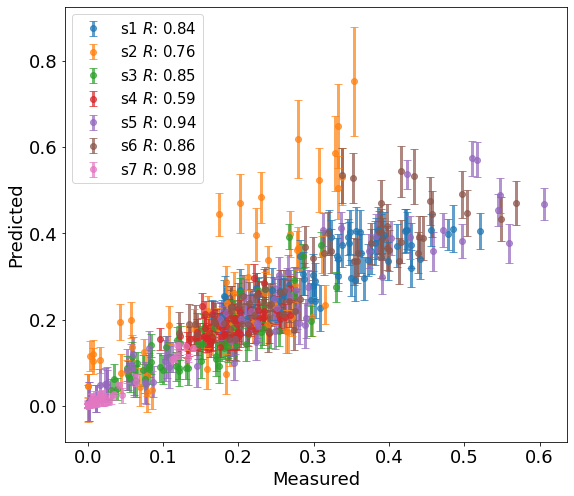

0.8513984332220248


In [18]:
plt.figure(figsize=(9,8))
r_vals = []
for i,s in enumerate(species):
    y_inds = np.in1d(kfold_species_names, s)
    y_s_true = np.array(kfold_y_true)[y_inds]
    y_s_pred = np.array(kfold_y_pred)[y_inds]
    y_s_stdv = np.array(kfold_y_stdv)[y_inds]
    
    # throw out zeros
    y_inds = y_s_true > 0.
    y_s_true = y_s_true[y_inds]
    y_s_pred = y_s_pred[y_inds]
    y_s_stdv = y_s_stdv[y_inds]
    
    r = linregress(y_s_true, y_s_pred).rvalue
    r_vals.append(r)
    plt.errorbar(y_s_true, y_s_pred, yerr = y_s_stdv, 
                 label=s+r" $R$: {:.2f}".format(r),
                 linewidth=3, capsize=4, c=f"C{i}", linestyle='none', marker='o', alpha=.7)

plt.legend(fontsize=15)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.xlabel("Measured", fontsize=18)
plt.ylabel("Predicted", fontsize=18)
plt.savefig("Results/glv_kfold.pdf", dpi=150)
plt.show()
print(np.median(r_vals))